## NYC Yellow Cab Analysis


##### Team member: 
Zhangcheng Guo, Chang-Han Chen, Ziqi Shan, Tsung Yen Wu, Jiahui Xu

##### Concerns:
With blooming growth in for-hire vehicle business model in New York City such as Uber and Lyft, tradinational taxi industry has felt the threat and observed shrinking of indurstry. We aim to observe available datasets and provide suggestions for yellow cab drivers to survive the competition.

##### Objective: 
Our goal is to help optimize profit and imporve time efficiency for yellow taxi drivers in New York City. We aim to help both full-time and part-time yellow cab drivers to find the best location and work time by analyzing what day of the week to work, what time of the day to work, in what weather to work, and where to work.

##### Raw Data Profile:
‘Yellow Taxi Trip Records’, public data acquired from NYC government website, records yellow taxi trips from 2009 to the current date. Datasets record various trip information such as time, pick up/drop off location ID and trip price. 

Climate dataset was brought into analysis to observe potential affect of climate on taxi trips. 'Climate Data Online - Daily Summary', retrieved from NOAA website, records climate information for NYC region.

'Taxi Zone Lookup Table' from NYC government webcite helps to interpret location IDs into zone names.

From these information, we aim to analyze and predict the best time, place and season for drivers to work to earn the most money.

##### Data source link : 
‘Yellow Taxi Trip Records’: <https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page> 

'Climate Data Online - Daily Summary': <https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US360019/detail>

'Taxi Zone Lookup Table': <https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page>



##### Raw Data Cleaning:
NYC government website provides detailed and unfiltered yellow taxi data for each month since 2009; therefore, datasets need to be cleaned before conducting analysis. With available dataset, we selected records in 2019 to insure most relevent information that can reflect current days. Intentionally, the dataset in 2020 is avoided considering the potential impact of the Covid-19 pandemic in NYC on yellow taxi.

Each month contains great number of data. For example, In August 2019, more than 1 million trips were recorded. Considering efficiency when performing analysis on datasets and limitations in terms of data size and budget on Google Cloud Platform, 10% of the data in each month of 2019 is randomly sampled and unioned into one table for 2019.

Below is an example of random selection process for January datasets:

In [77]:
%%bigquery
select * from `ba-775-a-team-1.taxi.01`
where rand() <0.01
limit 5

VendorID      tpep_pickup_datetime     tpep_dropoff_datetime  \
0         2 2019-01-22 23:43:35+00:00 2019-01-23 00:05:21+00:00   
1         2 2019-01-01 01:31:35+00:00 2019-01-01 02:07:45+00:00   
2         2 2019-01-01 02:16:33+00:00 2019-01-01 02:38:55+00:00   
3         1 2019-01-01 04:13:41+00:00 2019-01-01 04:38:58+00:00   
4         1 2019-01-13 03:29:10+00:00 2019-01-13 03:50:03+00:00   

   passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0                1           8.41           1               False   
1                1           7.30           1               False   
2                1          11.29           1               False   
3                1           9.00           1               False   
4                3          10.70           1               False   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           138           230             1         26.0    0.5      0.5   
1            79           166             1         27.5    0.5      0.5   
2            42           265             1         32.5    0.5      0.5   
3           164            17             1         28.0    0.5      0.5   
4           114            42             1         31.5    0.5      0.5   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0        5.88          5.76                    0.3         38.94   
1        5.76          0.00                    0.3         34.56   
2        6.76          0.00                    0.3         40.56   
3        7.00          5.76                    0.3         42.06   
4        6.55          0.00                    0.3         39.35   

  congestion_surcharge  
0                    0  
1                 None  
2                 None  
3                 None  
4                 None

After combining sampled datasets, some invalid rows were observed. First, trips with fare_amount less than 2.5 is considered to be invalid since the initial charge for yellow taxi is 2.5 dollars. Further, some trips recording Pick Up or Drop off location as 264 or 265,interpreted as NA or NV, are speculated to be invalid trips since no location was recorded.

The filtering process is presented below.

In [82]:
%%bigquery
SELECT * FROM `ba-775-a-team-1.data.taxi_data`
WHERE
 fare_amount  >= 2.5
 and PULocationID <> 265
 and PULocationID <> 264
 and DOLocationID <> 265
 and DOLocationID <> 264
limit 5

VendorID                  datetime     tpep_dropoff_datetime  \
0         2 2019-01-24 12:54:30+00:00 2019-01-24 13:04:54+00:00   
1         2 2019-01-24 06:22:38+00:00 2019-01-24 06:33:32+00:00   
2         2 2019-01-24 09:25:13+00:00 2019-01-24 09:40:08+00:00   
3         2 2019-01-24 07:30:28+00:00 2019-01-24 07:52:10+00:00   
4         1 2019-01-24 09:12:09+00:00 2019-01-24 09:39:04+00:00   

   passenger_count  distance  RatecodeID  store_and_fwd_flag  PULocationID  \
0                1      0.83           1               False           140   
1                1      1.40           1               False            48   
2                3      1.88           1               False           186   
3                1      6.44           1               False           170   
4                1      1.40           1               False           236   

                         source  DOLocationID  ...  price  \
0               Lenox Hill East           141  ...  10.56   
1                  Clinton East           233  ...   9.30   
2  Penn Station/Madison Sq West           143  ...  14.75   
3                   Murray Hill            13  ...  27.36   
4         Upper East Side North           163  ...  19.32   

   congestion_surcharge        date  day  month  hour   AWND  PRCP  SNOW  TAVG  
0                   0.0  2019-01-24   24      1    12  21.25  1.68   0.0    53  
1                   0.0  2019-01-24   24      1     6  21.25  1.68   0.0    53  
2                   0.0  2019-01-24   24      1     9  21.25  1.68   0.0    53  
3                   0.0  2019-01-24   24      1     7  21.25  1.68   0.0    53  
4                   0.0  2019-01-24   24      1     9  21.25  1.68   0.0    53  

[5 rows x 28 columns]

In addition, throughout analyzing process, more data flaws in dataset have been found. For example, some data in the column is recorded to negative or zero, which leads to investigation in transaction type where some are either invalid or incomplete. In addition, some trips recorded a distance of 0 which cannot be explained logically. Therefore, we have decided to eliminate the trips mentioned above. 

Note that for all cleaning processes, a total of around 2000 trips were filtered, which only accounts for 0.3% of our observing dataset. With such small amount of data eliminated, we believe we can still produce reliable output since it does not analysis output significantlly.

### Analysis Topics

To achieve our objective, we chose aspects in time, pick up and drop off location, distance traveled and climate to observe underlying affects on yellow cab trips. All data processing performed on Google Big Query.

### Day of week

We analyzed the data to find which day of the week has the highest count of rides. We found out that Thursday and Friday are the busiest day out of the week.

Weekday results were produced by using extracting DAYOFWEEK function on Datetime. We grouped count of trips by weekdays to observe dataset.

Visiual presentation listed below.

<img src="https://github.com/zckristy/BA775/blob/main/weekday.png?raw=true" width=300, height=300, align = 'center'>

In [85]:
%%bigquery
SELECT
  weekdays, COUNT(*) AS counts
FROM (
  SELECT
    DATETIME, FORMAT_DATE('%A', EXTRACT(Date
      FROM
        datetime)) AS weekdays,
  FROM `ba-775-a-team-1.data.taxi_data` )
GROUP BY
  weekdays
ORDER BY
  counts DESC

weekdays  counts
0   Thursday  131488
1     Friday  129404
2  Wednesday  127459
3    Tuesday  124233
4   Saturday  121309
5     Monday  109299
6     Sunday  103817

### Hour of Day
#### At what hour of the day occurs the most trips?

We mean to organize trip information regarding hours of the day to potentially observe the most time efficient hours for drivers to work. From organized data, we can observe that the peak hour is between 18:00 - 20:00. Generally during dinner time and communting time from work. 

Related analysis presented below.

Number of trips by hour:

<img src="https://github.com/zckristy/BA775/blob/main/hour%20count.png?raw=true" width=300, height=300, align = 'center'>

In [87]:
%%bigquery
SELECT
  hour,
  COUNT(hour)AS number_of_trips,
  ROUND(COUNT(*) / SUM(COUNT(*)) over () *100,2) as percentage
FROM
  `ba-775-a-team-1.data.taxi_data`
GROUP BY
  hour
ORDER BY
  COUNT(hour) DESC
limit 5

hour  number_of_trips  percentage
0    18            56816        6.71
1    19            53086        6.27
2    17            50605        5.97
3    20            47984        5.67
4    21            47816        5.65

#### At what hour of the day recorda the highest fare?


In contrast of trip volume, we observed highest hourly price is from 4 - 5 in the morning, where the adjusted price for overnight surcharge is a mean of earning more given same amount of time worked.

In [ ]:
%%bigquery
select 
  hour,
  round(avg(price),2) as avg_price,
  round(stddev_pop(price),2) as std_of_avg_price,
  min(price) as min_price,
  max(price) as max_price
FROM (
  SELECT extract (hour from datetime) as hour, price
  FROM
    ba-775-a-team-1.data.taxi_data)
group by hour
ORDER BY
  avg(price) desc
limit 10

Image belowe is presented to visualize the difference between hourly trip volume and price. 

<img src="https://github.com/zckristy/BA775/blob/main/pv.png?raw=true" width=700, align = 'center'>

Combining two-time variables weedday and hour, we are able to acquire more specific information on populated taxi trips.

and visualization listed below.

<img src="https://github.com/zckristy/BA775/blob/main/timepc.png?raw=true" width=800,  align = 'center'>

In [90]:
%%bigquery
SELECT
  weekdays, extract (hour from datetime) as hour, COUNT(*) AS counts
FROM (
  SELECT
    DATETIME, FORMAT_DATE('%A', EXTRACT(Date
      FROM
        datetime)) AS weekdays,
  FROM `ba-775-a-team-1.data.taxi_data` )
GROUP BY
  weekdays, hour
ORDER BY
  counts DESC
limit 5

weekdays  hour  counts
0  Wednesday    18    8863
1    Tuesday    18    8743
2   Thursday    18    8684
3     Friday    18    8676
4     Friday    19    8480

### Distance

#### Which pick-up location has the most diverse destination?

From the result, we can see that JFK Airport, which is viewed as a start point, has the most number of destinations. Besides, the top 5 showed in the table are basically traffic junction or downtown area, which indicates that the location has a higher visitor flow rate usually gets a more diverse destination.

In [ ]:
%%bigquery
SELECT source as start, array_agg( distinct destination) as destination, ARRAY_LENGTH(ARRAY_AGG( distinct destination)) as count_destination
from `ba-775-a-team-1.data.taxi_data`
group by source
order by count_destination DESC
limit 5

#### Which area for the driver is most likely to pick up passenger?

According to the table, it seems that Upper East Side South is the most popular pick-up location. 

<img src="https://github.com/zckristy/BA775/blob/main/distance.gif?raw=true" width=700, align = 'center'>
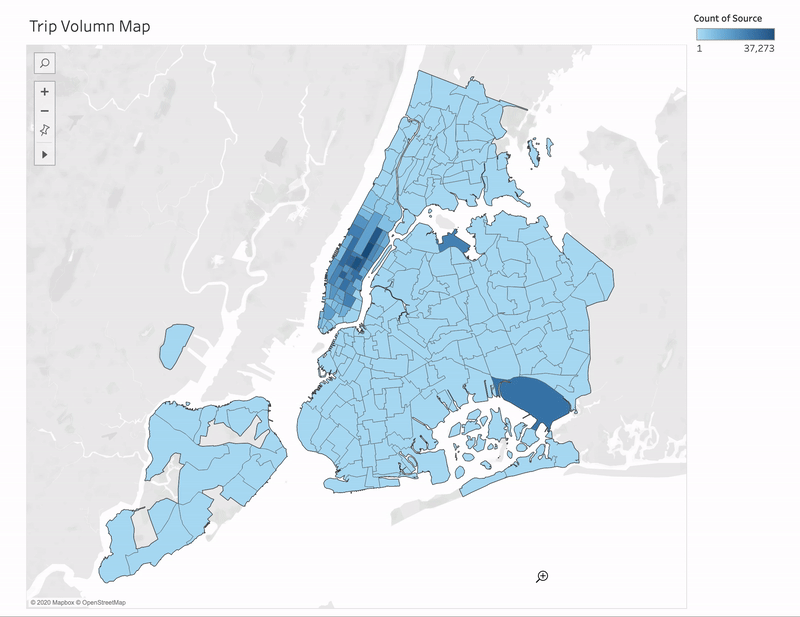

In [92]:
%%bigquery
SELECT distinct source as start, count(*) as count, string_agg(destination, ' | ' limit 10) as destination
FROM `ba-775-a-team-1.data.taxi_data` 
where distance <> 0.0
group by source
order by count DESC
limit 5

start  count  \
0         Upper East Side South  37273   
1                Midtown Center  35283   
2         Upper East Side North  33600   
3                  Midtown East  31396   
4  Penn Station/Madison Sq West  30944   

                                         destination  
0  Midtown Center | Midtown North | Upper East Si...  
1  Penn Station/Madison Sq West | Midtown North |...  
2  Midtown North | Central Park | Upper West Side...  
3  LaGuardia Airport | LaGuardia Airport | Midtow...  
4  Lincoln Square West | Midtown North | Kips Bay...

#### What start locations are more likely to make a long trip?

Generally, if a driver picks up passengers at Bloomfield/Port Richmond/Prince's Bay, it is more likely for him/her to make a long trip. And according to the table, drivers can decide whether to run a long-distance trip or not depending on the price.

<img src="https://github.com/zckristy/BA775/blob/main/distance.png?raw=true" width=800,  align = 'center'>


In [93]:
%%bigquery
select source as start, round(avg(distance),2) as avg_distance, round(avg(price),2) as avg_price, round(avg(tip_amount),2) as avg_tips
from `ba-775-a-team-1.data.taxi_data`
group by start
order by avg_distance DESC
limit 5

start  avg_distance  avg_price  avg_tips
0            Bloomfield/Emerson Hill         34.91      94.05       0.0
1                      Port Richmond         27.05      99.66       0.0
2  Eltingville/Annadale/Prince's Bay         26.03      91.92       0.0
3                      Arden Heights         23.78      75.20       0.0
4        Heartland Village/Todt Hill         23.47      70.55       0.0

For this information, we ploted average price against distance traveled for each location. Notice that in the graph below, some locations significantlly deviates from expected price. We consider trips from these locations to have higher tips, which we recommand drivers to pick up passengers for more amount paid given same distance traveled. 

<img src="https://github.com/zckristy/BA775/blob/main/pd.png?raw=true" width=800,  align = 'center'>

### On any day of the week, which pickup area is most likely to earn the most profit for drivers?

To observe this interest, we grouped the data by source (pickup location) and average price. 

For example, we can find out which area has the highest average_price on Sunday by using the following code:


In [94]:
%%bigquery
SELECT DAYOFWEEK, round(avg(price),2) as avg_price, source
FROM (SELECT EXTRACT(DAYOFWEEK from datetime) as DAYOFWEEK, price, source
FROM `ba-775-a-team-1.data.taxi_data` )
where DAYOFWEEK = 1
group by DAYOFWEEK, source
order by avg(price) desc
limit 5

DAYOFWEEK  avg_price                        source
0          1      99.66                 Port Richmond
1          1      78.05                    Ozone Park
2          1      77.60                Newark Airport
3          1      68.29                   City Island
4          1      64.04  Flushing Meadows-Corona Park

After computing average price, we want to know which ‘start’(pick up location) is the busiest. We counted number of trips ocurred by pickup location.

For example, we can find which area is the busiest on Sunday by using the following code:

In [ ]:
%%bigquery
SELECT start, count(start) start_count
FROM 
(SELECT distinct source as start, destination, count(*) as count, count(distinct date) as num_date, ceiling(count(*)/count(distinct date)) as num_per_day, string_agg(distinct cast(date as string), ' | ' order by cast(date as string)limit 10) as date, EXTRACT(DAYOFWEEK FROM datetime) DayofWeek
FROM `ba-775-a-team-1.data.taxi_data` 
where distance <> 0.0
group by source, destination, datetime
order by num_per_day DESC)
where DayofWeek = 1
group by start
order by start_count DESC
limit 5

Lastly, we join these two tables and observe the total earning for each location on any day of the week. We do so by multiplying the count of trips and average prices.

Now, we can identify which pickup location makes the most profit on any day of the week. In anlysis above, airports like LGA and JFK have significantly more trips, considering its longer average distance travelled for drivers, in analysis below, we excluded them to observe better on how the reat areas perform.

For example, we can find out which area makes most profit on Sunday by using following code:

In [ ]:
%%bigquery
select
start, ROUND(sum(total_earning),2)sum_total_earning
from
(SELECT start, start_count, avg_price, (start_count*avg_price)total_earning 
 FROM `ba-775-a-team-1.data.dayofweek_totalearning` 
where dayofweek = 1)
where start not like "%Airport"

group by start 
order by sum_total_earning desc
limit 5

Here is the screenshots of the output by weekdays:

Sunday, Monday, Tuesday:

<img src='https://github.com/zckristy/BA775/blob/main/Monday_total_earning%20(1).jpeg?raw=true' width=270 > <img src="https://github.com/zckristy/BA775/blob/main/Monday_total_earning%20(1).jpeg?raw=true" width=270> <img src="https://github.com/zckristy/BA775/blob/main/Tuesday_total_earning.jpeg?raw=true" width=270>

Wednesday, Thursday, Friday, Saturday:

<img src="https://github.com/zckristy/BA775/blob/main/Wednesday_total_earning.jpeg?raw=true" width=270, > <img src="https://github.com/zckristy/BA775/blob/main/Thursday_total_earning.jpeg?raw=true" width=270, >

<img src="https://github.com/zckristy/BA775/blob/main/Friday_total_earning%20(1).jpeg?raw=true" width=270, > <img src="https://github.com/zckristy/BA775/blob/main/Saturday_total_earning%20(1).jpeg?raw=true" width=270, >



A map visualization of outout above:


<img src="https://github.com/zckristy/BA775/blob/main/ezgif.com-video-to-gif-8%20(1).gif?raw=true">

### Weather Condition

#### Are there more Yellow Cab rides on rainy days, snowy days, or windy days?

In this section, we discuss the popularity of Yellow Cab rides in different weather conditions. We define four different weather conditions--PRCP(precipitation), SNOW (snow depths), AWND(wind speed), and temperature. We conduct a simple calculation and show how many rides per month in different weather conditions. 

From this result, we can tell when the total ride is the largest, the wind speed is high, snowfall is large, and the temperature is low. Analyzing these characteristics, we have found that all climate attributes can find relevence in terms of seasons. Therefore, we can reasonably conclude that in New York City, trip rides in summer is lower than trips rides in winter.

<img src ="https://github.com/zckristy/BA775/blob/main/weathercondition.jpg?raw=true">

In [99]:
%%bigquery
SELECT
  EXTRACT( month
  FROM (datetime )) AS MONTH, ROUND(AVG(PRCP),3)AS PRCP, ROUND(AVG(SNOW),3) AS SNOW, ROUND(AVG(AWND),3) AS AWND,
  COUNT(*)AS COUNT, ROUND(AVG(TAVG),3) AS TEMP
FROM
  `ba-775-a-team-1.data.taxi_data`
GROUP BY
  month
ORDER BY
  count DESC
limit 5

MONTH   PRCP   SNOW    AWND  COUNT    TEMP
0      3  0.373  0.867  13.451  79502  41.310
1      1  0.470  0.302  14.322  76760  33.790
2      5  0.831  0.000  11.183  76315  62.456
3      4  0.497  0.000  12.967  75374  54.907
4     10  0.710  0.000  12.944  72820  60.998

### Use Bigquery Machine Learning To Predict Possible Trips

To help yellow cab drivers better utlize our analysis, we have decided to predict the expected trips that occur during certain input conditions, so that dirvers have the option to choose which destinations to go and pick up passengers.

#### Under what condition it affects trip counts?

Now, we are trying to predict the number of possible trips that can happen given some representative features. We select the last 2 months (November and December) as evaluating data, and the rest as training data consideirng sequence of occurrence.

Since we want to predict the expected trip counts at a given weather condition, at a certain place, or at a certain time using Big Query machine learning, the first thing is to determine class of independent variables. We decided to catergorize some input varibales since we anticipate drivers not being interested in exact time or specific temperature, but rather a time range or generalized weather conditions. Therefore, we have decided to categorized climate conditions listed as below.

PRCP_level(precipitation in inches): [0, 0.5], [0.5, 1], ..., [3.5, 4], [4, Inf];

AWND_level(average wind speed in mph): [0, 10], [10, 15], [15, 20], [20, 25], [25, Inf];

SNOW_level(snowfall in inches): [0, 2], [2, 4], [4, 6], [6, Inf];

TAVG_level(average temperature in Fahrenheit): [-Inf, 10], [10, 20], [20, 30], ..., [70, 80], [80, Inf];

Same theory applies to distance travelling, and is catergorized as the following.

distance_level(in miles): [0, 5], [5, 10], ..., [75, 80], [80, Inf];

Since trip counts can be considered continuous variables, we performed linear regression model to predict trip counts.

#### At the beginning, we simply selected time variables as dependent variables to predict number of trips.

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `ba-775-a-team-1.data.trips_pred_model_1`
OPTIONS(model_type = 'linear_reg', labels = ['count_trips'])
AS
SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month NOT IN (11, 12)
GROUP BY weekdays, hour_str

In [100]:
%%bigquery
SELECT
    SQRT(mean_squared_error) AS rmse
FROM
    ML.EVALUATE(MODEL `ba-775-a-team-1.data.trips_pred_model_1`,
    (SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month IN (11, 12)
GROUP BY weekdays, hour_str
    ))

rmse
0  3766.49578

Now, we obtain the bigquery machine model. The rooted mean squared error is +/-3,766.50 using the testing data, which in our case is too large to be accepted; therefore, we conclude with only time variable, trips cannot be explained properly. 

#### Next try. We put time, distance, and weather features together to see if we can predict it better.

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `ba-775-a-team-1.data.trips_pred_model_2`
OPTIONS(model_type = 'linear_reg', labels = ['count_trips'])
AS
SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str,
    CASE WHEN distance < 5 THEN 'distance_0_5'
        WHEN distance BETWEEN 5 AND 10 THEN 'distance_5_10'
        WHEN distance BETWEEN 10 AND 15 THEN 'distance_10_15'
        WHEN distance BETWEEN 15 AND 20 THEN 'distance_15_20'
        WHEN distance BETWEEN 20 AND 25 THEN 'distance_20_25'
        WHEN distance BETWEEN 25 AND 30 THEN 'distance_25_30'
        WHEN distance BETWEEN 30 AND 35 THEN 'distance_30_35'
        WHEN distance BETWEEN 35 AND 40 THEN 'distance_35_40'
        WHEN distance BETWEEN 40 AND 45 THEN 'distance_40_45'
        WHEN distance BETWEEN 45 AND 50 THEN 'distance_45_50'
        WHEN distance BETWEEN 50 AND 55 THEN 'distance_50_55'
        WHEN distance BETWEEN 55 AND 60 THEN 'distance_55_60'
        WHEN distance BETWEEN 60 AND 65 THEN 'distance_60_65'
        WHEN distance BETWEEN 65 AND 70 THEN 'distance_65_70'
        WHEN distance BETWEEN 70 AND 75 THEN 'distance_70_75'
        WHEN distance BETWEEN 75 AND 80 THEN 'distance_75_80'
        WHEN distance > 80 THEN 'distance_80up'
        END AS distance_level,
    CASE WHEN PRCP < 0.5 THEN 'PRCP_0_0.5'
        WHEN PRCP BETWEEN 0.5 AND 1 THEN 'PRCP_0.5_1'
        WHEN PRCP BETWEEN 1 AND 1.5 THEN 'PRCP_1_1.5'
        WHEN PRCP BETWEEN 1.5 AND 2 THEN 'PRCP_1.5_2'
        WHEN PRCP BETWEEN 2 AND 2.5 THEN 'PRCP_2_2.5'
        WHEN PRCP BETWEEN 2.5 AND 3 THEN 'PRCP_2.5_3'
        WHEN PRCP BETWEEN 3 AND 3.5 THEN 'PRCP_3_3.5'
        WHEN PRCP BETWEEN 3.5 AND 4 THEN 'PRCP_3.5_4'
        WHEN PRCP > 4 THEN 'PRCP_4up'
        END AS PRCP_level,
    CASE WHEN AWND < 10 THEN 'AWND_0_10'
        WHEN AWND BETWEEN 10 AND 15 THEN 'AWND_10_15'
        WHEN AWND BETWEEN 15 AND 20 THEN 'AWND_15_20'
        WHEN AWND BETWEEN 20 AND 25 THEN 'AWND_25_30'
        WHEN AWND > 25 THEN 'AWND_25up'
        END AS AWND_level,
    CASE WHEN SNOW < 2 THEN 'SNOW_0_2'
        WHEN SNOW BETWEEN 2 AND 4 THEN 'SNOW_2_4'
        WHEN SNOW BETWEEN 4 AND 6 THEN 'SNOW_4_6'
        WHEN SNOW > 6 THEN 'SNOW_6up'
        END AS SNOW_level,
    CASE WHEN TAVG < 10 THEN 'TAVG_below10'
        WHEN TAVG BETWEEN 10 AND 20 THEN 'TAVG_10_20'
        WHEN TAVG BETWEEN 20 AND 30 THEN 'TAVG_20_30'
        WHEN TAVG BETWEEN 30 AND 40 THEN 'TAVG_30_40'
        WHEN TAVG BETWEEN 40 AND 50 THEN 'TAVG_40_50'
        WHEN TAVG BETWEEN 50 AND 60 THEN 'TAVG_50_60'
        WHEN TAVG BETWEEN 60 AND 70 THEN 'TAVG_60_70'
        WHEN TAVG BETWEEN 70 AND 80 THEN 'TAVG_70_80'
        WHEN TAVG > 80 THEN 'TAVG_80up'
        END AS TAVG_level,
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month NOT IN (11, 12)
GROUP BY weekdays, hour_str, distance_level, PRCP_level, AWND_level, SNOW_level, TAVG_level

In [116]:
%%bigquery
SELECT
    SQRT(mean_squared_error) AS rmse
FROM
    ML.EVALUATE(MODEL `ba-775-a-team-1.data.trips_pred_model_2`,
    (SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str,
    CASE WHEN distance < 5 THEN 'distance_0_5'
        WHEN distance BETWEEN 5 AND 10 THEN 'distance_5_10'
        WHEN distance BETWEEN 10 AND 15 THEN 'distance_10_15'
        WHEN distance BETWEEN 15 AND 20 THEN 'distance_15_20'
        WHEN distance BETWEEN 20 AND 25 THEN 'distance_20_25'
        WHEN distance BETWEEN 25 AND 30 THEN 'distance_25_30'
        WHEN distance BETWEEN 30 AND 35 THEN 'distance_30_35'
        WHEN distance BETWEEN 35 AND 40 THEN 'distance_35_40'
        WHEN distance BETWEEN 40 AND 45 THEN 'distance_40_45'
        WHEN distance BETWEEN 45 AND 50 THEN 'distance_45_50'
        WHEN distance BETWEEN 50 AND 55 THEN 'distance_50_55'
        WHEN distance BETWEEN 55 AND 60 THEN 'distance_55_60'
        WHEN distance BETWEEN 60 AND 65 THEN 'distance_60_65'
        WHEN distance BETWEEN 65 AND 70 THEN 'distance_65_70'
        WHEN distance BETWEEN 70 AND 75 THEN 'distance_70_75'
        WHEN distance BETWEEN 75 AND 80 THEN 'distance_75_80'
        WHEN distance > 80 THEN 'distance_80up'
        END AS distance_level,
    CASE WHEN PRCP < 0.5 THEN 'PRCP_0_0.5'
        WHEN PRCP BETWEEN 0.5 AND 1 THEN 'PRCP_0.5_1'
        WHEN PRCP BETWEEN 1 AND 1.5 THEN 'PRCP_1_1.5'
        WHEN PRCP BETWEEN 1.5 AND 2 THEN 'PRCP_1.5_2'
        WHEN PRCP BETWEEN 2 AND 2.5 THEN 'PRCP_2_2.5'
        WHEN PRCP BETWEEN 2.5 AND 3 THEN 'PRCP_2.5_3'
        WHEN PRCP BETWEEN 3 AND 3.5 THEN 'PRCP_3_3.5'
        WHEN PRCP BETWEEN 3.5 AND 4 THEN 'PRCP_3.5_4'
        WHEN PRCP > 4 THEN 'PRCP_4up'
        END AS PRCP_level,
    CASE WHEN AWND < 10 THEN 'AWND_0_10'
        WHEN AWND BETWEEN 10 AND 15 THEN 'AWND_10_15'
        WHEN AWND BETWEEN 15 AND 20 THEN 'AWND_15_20'
        WHEN AWND BETWEEN 20 AND 25 THEN 'AWND_25_30'
        WHEN AWND > 25 THEN 'AWND_25up'
        END AS AWND_level,
    CASE WHEN SNOW < 2 THEN 'SNOW_0_2'
        WHEN SNOW BETWEEN 2 AND 4 THEN 'SNOW_2_4'
        WHEN SNOW BETWEEN 4 AND 6 THEN 'SNOW_4_6'
        WHEN SNOW > 6 THEN 'SNOW_6up'
        END AS SNOW_level,
    CASE WHEN TAVG < 10 THEN 'TAVG_below10'
        WHEN TAVG BETWEEN 10 AND 20 THEN 'TAVG_10_20'
        WHEN TAVG BETWEEN 20 AND 30 THEN 'TAVG_20_30'
        WHEN TAVG BETWEEN 30 AND 40 THEN 'TAVG_30_40'
        WHEN TAVG BETWEEN 40 AND 50 THEN 'TAVG_40_50'
        WHEN TAVG BETWEEN 50 AND 60 THEN 'TAVG_50_60'
        WHEN TAVG BETWEEN 60 AND 70 THEN 'TAVG_60_70'
        WHEN TAVG BETWEEN 70 AND 80 THEN 'TAVG_70_80'
        WHEN TAVG > 80 THEN 'TAVG_80up'
        END AS TAVG_level,
    FROM
        `ba-775-a-team-1.data.taxi_data`
    WHERE month IN (11, 12)
    GROUP BY weekdays, hour_str, distance_level, PRCP_level, AWND_level, SNOW_level, TAVG_level
        ))

rmse
0  34.955364

With time, distance, price and weather input, rooted mean squared error is greatly improved.

#### Next try. We try to add the start location feature and drop both AWND(average wind speed) and SNOW(snowfall) to see if we can obtain a better prediction result.

We observed correlation between average wind and snow depths that can be explained by season; therefore, we decided to only choose temperature variables.

In [117]:
%%bigquery
CREATE OR REPLACE MODEL `ba-775-a-team-1.data.trips_pred_model_final`
OPTIONS(model_type = 'linear_reg', labels = ['count_trips'])
AS
SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str,
    CASE WHEN distance < 5 THEN 'distance_0_5'
        WHEN distance BETWEEN 5 AND 10 THEN 'distance_5_10'
        WHEN distance BETWEEN 10 AND 15 THEN 'distance_10_15'
        WHEN distance BETWEEN 15 AND 20 THEN 'distance_15_20'
        WHEN distance BETWEEN 20 AND 25 THEN 'distance_20_25'
        WHEN distance BETWEEN 25 AND 30 THEN 'distance_25_30'
        WHEN distance BETWEEN 30 AND 35 THEN 'distance_30_35'
        WHEN distance BETWEEN 35 AND 40 THEN 'distance_35_40'
        WHEN distance BETWEEN 40 AND 45 THEN 'distance_40_45'
        WHEN distance BETWEEN 45 AND 50 THEN 'distance_45_50'
        WHEN distance BETWEEN 50 AND 55 THEN 'distance_50_55'
        WHEN distance BETWEEN 55 AND 60 THEN 'distance_55_60'
        WHEN distance BETWEEN 60 AND 65 THEN 'distance_60_65'
        WHEN distance BETWEEN 65 AND 70 THEN 'distance_65_70'
        WHEN distance BETWEEN 70 AND 75 THEN 'distance_70_75'
        WHEN distance BETWEEN 75 AND 80 THEN 'distance_75_80'
        WHEN distance > 80 THEN 'distance_80up'
        END AS distance_level,
    CASE WHEN PRCP < 0.5 THEN 'PRCP_0_0.5'
        WHEN PRCP BETWEEN 0.5 AND 1 THEN 'PRCP_0.5_1'
        WHEN PRCP BETWEEN 1 AND 1.5 THEN 'PRCP_1_1.5'
        WHEN PRCP BETWEEN 1.5 AND 2 THEN 'PRCP_1.5_2'
        WHEN PRCP BETWEEN 2 AND 2.5 THEN 'PRCP_2_2.5'
        WHEN PRCP BETWEEN 2.5 AND 3 THEN 'PRCP_2.5_3'
        WHEN PRCP BETWEEN 3 AND 3.5 THEN 'PRCP_3_3.5'
        WHEN PRCP BETWEEN 3.5 AND 4 THEN 'PRCP_3.5_4'
        WHEN PRCP > 4 THEN 'PRCP_4up'
        END AS PRCP_level,

    CASE WHEN TAVG < 10 THEN 'TAVG_below10'
        WHEN TAVG BETWEEN 10 AND 20 THEN 'TAVG_10_20'
        WHEN TAVG BETWEEN 20 AND 30 THEN 'TAVG_20_30'
        WHEN TAVG BETWEEN 30 AND 40 THEN 'TAVG_30_40'
        WHEN TAVG BETWEEN 40 AND 50 THEN 'TAVG_40_50'
        WHEN TAVG BETWEEN 50 AND 60 THEN 'TAVG_50_60'
        WHEN TAVG BETWEEN 60 AND 70 THEN 'TAVG_60_70'
        WHEN TAVG BETWEEN 70 AND 80 THEN 'TAVG_70_80'
        WHEN TAVG > 80 THEN 'TAVG_80up'
        END AS TAVG_level,
    source AS start_location
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month NOT IN (11, 12)
GROUP BY weekdays, hour_str, distance_level,PRCP_level, TAVG_level, start_location

Empty DataFrame
Columns: []
Index: []

In [118]:
%%bigquery
SELECT
    SQRT(mean_squared_error) AS rmse
FROM
    ML.EVALUATE(MODEL `ba-775-a-team-1.data.trips_pred_model_final`,(
SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str,
    CASE WHEN distance < 5 THEN 'distance_0_5'
        WHEN distance BETWEEN 5 AND 10 THEN 'distance_5_10'
        WHEN distance BETWEEN 10 AND 15 THEN 'distance_10_15'
        WHEN distance BETWEEN 15 AND 20 THEN 'distance_15_20'
        WHEN distance BETWEEN 20 AND 25 THEN 'distance_20_25'
        WHEN distance BETWEEN 25 AND 30 THEN 'distance_25_30'
        WHEN distance BETWEEN 30 AND 35 THEN 'distance_30_35'
        WHEN distance BETWEEN 35 AND 40 THEN 'distance_35_40'
        WHEN distance BETWEEN 40 AND 45 THEN 'distance_40_45'
        WHEN distance BETWEEN 45 AND 50 THEN 'distance_45_50'
        WHEN distance BETWEEN 50 AND 55 THEN 'distance_50_55'
        WHEN distance BETWEEN 55 AND 60 THEN 'distance_55_60'
        WHEN distance BETWEEN 60 AND 65 THEN 'distance_60_65'
        WHEN distance BETWEEN 65 AND 70 THEN 'distance_65_70'
        WHEN distance BETWEEN 70 AND 75 THEN 'distance_70_75'
        WHEN distance BETWEEN 75 AND 80 THEN 'distance_75_80'
        WHEN distance > 80 THEN 'distance_80up'
        END AS distance_level,
        
    CASE WHEN PRCP < 0.5 THEN 'PRCP_0_0.5'
        WHEN PRCP BETWEEN 0.5 AND 1 THEN 'PRCP_0.5_1'
        WHEN PRCP BETWEEN 1 AND 1.5 THEN 'PRCP_1_1.5'
        WHEN PRCP BETWEEN 1.5 AND 2 THEN 'PRCP_1.5_2'
        WHEN PRCP BETWEEN 2 AND 2.5 THEN 'PRCP_2_2.5'
        WHEN PRCP BETWEEN 2.5 AND 3 THEN 'PRCP_2.5_3'
        WHEN PRCP BETWEEN 3 AND 3.5 THEN 'PRCP_3_3.5'
        WHEN PRCP BETWEEN 3.5 AND 4 THEN 'PRCP_3.5_4'
        WHEN PRCP > 4 THEN 'PRCP_4up'
        END AS PRCP_level,
        
    CASE WHEN TAVG < 10 THEN 'TAVG_below10'
        WHEN TAVG BETWEEN 10 AND 20 THEN 'TAVG_10_20'
        WHEN TAVG BETWEEN 20 AND 30 THEN 'TAVG_20_30'
        WHEN TAVG BETWEEN 30 AND 40 THEN 'TAVG_30_40'
        WHEN TAVG BETWEEN 40 AND 50 THEN 'TAVG_40_50'
        WHEN TAVG BETWEEN 50 AND 60 THEN 'TAVG_50_60'
        WHEN TAVG BETWEEN 60 AND 70 THEN 'TAVG_60_70'
        WHEN TAVG BETWEEN 70 AND 80 THEN 'TAVG_70_80'
        WHEN TAVG > 80 THEN 'TAVG_80up'
        END AS TAVG_level,
    source AS start_location
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month NOT IN (11, 12)
GROUP BY weekdays, hour_str, distance_level,PRCP_level, TAVG_level, start_location))

rmse
0  4.037699

We have decided to adopt the last model since the rooted mean squared error is down to +/-4.0

#### With ML model `trips_pred_model_Final`, a prediction using evaluating dataset is presented below.

In [119]:
%%bigquery
SELECT
    *
FROM
    ML.PREDICT(MODEL `ba-775-a-team-1.data.trips_pred_model_final`,(
    
SELECT
    COUNT(*) AS count_trips,
    CAST(EXTRACT(DAYOFWEEK FROM datetime) AS STRING) AS weekdays,
    CAST(hour AS STRING) AS hour_str,
    CASE WHEN distance < 5 THEN 'distance_0_5'
        WHEN distance BETWEEN 5 AND 10 THEN 'distance_5_10'
        WHEN distance BETWEEN 10 AND 15 THEN 'distance_10_15'
        WHEN distance BETWEEN 15 AND 20 THEN 'distance_15_20'
        WHEN distance BETWEEN 20 AND 25 THEN 'distance_20_25'
        WHEN distance BETWEEN 25 AND 30 THEN 'distance_25_30'
        WHEN distance BETWEEN 30 AND 35 THEN 'distance_30_35'
        WHEN distance BETWEEN 35 AND 40 THEN 'distance_35_40'
        WHEN distance BETWEEN 40 AND 45 THEN 'distance_40_45'
        WHEN distance BETWEEN 45 AND 50 THEN 'distance_45_50'
        WHEN distance BETWEEN 50 AND 55 THEN 'distance_50_55'
        WHEN distance BETWEEN 55 AND 60 THEN 'distance_55_60'
        WHEN distance BETWEEN 60 AND 65 THEN 'distance_60_65'
        WHEN distance BETWEEN 65 AND 70 THEN 'distance_65_70'
        WHEN distance BETWEEN 70 AND 75 THEN 'distance_70_75'
        WHEN distance BETWEEN 75 AND 80 THEN 'distance_75_80'
        WHEN distance > 80 THEN 'distance_80up'
        END AS distance_level,
    CASE WHEN PRCP < 0.5 THEN 'PRCP_0_0.5'
        WHEN PRCP BETWEEN 0.5 AND 1 THEN 'PRCP_0.5_1'
        WHEN PRCP BETWEEN 1 AND 1.5 THEN 'PRCP_1_1.5'
        WHEN PRCP BETWEEN 1.5 AND 2 THEN 'PRCP_1.5_2'
        WHEN PRCP BETWEEN 2 AND 2.5 THEN 'PRCP_2_2.5'
        WHEN PRCP BETWEEN 2.5 AND 3 THEN 'PRCP_2.5_3'
        WHEN PRCP BETWEEN 3 AND 3.5 THEN 'PRCP_3_3.5'
        WHEN PRCP BETWEEN 3.5 AND 4 THEN 'PRCP_3.5_4'
        WHEN PRCP > 4 THEN 'PRCP_4up'
        END AS PRCP_level,
    CASE WHEN TAVG < 10 THEN 'TAVG_below10'
        WHEN TAVG BETWEEN 10 AND 20 THEN 'TAVG_10_20'
        WHEN TAVG BETWEEN 20 AND 30 THEN 'TAVG_20_30'
        WHEN TAVG BETWEEN 30 AND 40 THEN 'TAVG_30_40'
        WHEN TAVG BETWEEN 40 AND 50 THEN 'TAVG_40_50'
        WHEN TAVG BETWEEN 50 AND 60 THEN 'TAVG_50_60'
        WHEN TAVG BETWEEN 60 AND 70 THEN 'TAVG_60_70'
        WHEN TAVG BETWEEN 70 AND 80 THEN 'TAVG_70_80'
        WHEN TAVG > 80 THEN 'TAVG_80up'
        END AS TAVG_level,
    source AS start_location
FROM
    `ba-775-a-team-1.data.taxi_data`
WHERE month NOT IN (11, 12)
GROUP BY weekdays, hour_str, distance_level, PRCP_level, TAVG_level, start_location ))

order by predicted_count_trips desc
limit 5

predicted_count_trips  count_trips weekdays hour_str distance_level  \
0              12.349760           29        4       18   distance_0_5   
1              12.308986           40        3       18   distance_0_5   
2              12.232753           35        5       18   distance_0_5   
3              12.203757           47        4       18   distance_0_5   
4              12.165673           26        6       18   distance_0_5   

   PRCP_level  TAVG_level         start_location  
0  PRCP_0_0.5  TAVG_70_80  Upper East Side South  
1  PRCP_0_0.5  TAVG_70_80  Upper East Side South  
2  PRCP_0_0.5  TAVG_70_80  Upper East Side South  
3  PRCP_0_0.5  TAVG_60_70  Upper East Side South  
4  PRCP_0_0.5  TAVG_70_80  Upper East Side South

Note that during our analysis process, we have used only 10% of actual trips occured. Therefore, to roughly predict total expected trips occuring at a certain condition using hour model, multiply all trips counts by 10.

### Visual Representation on Tableau Dashboard

<img src = 'https://github.com/zckristy/BA775/blob/main/BA775%20Dashboard.JPG?raw=true'>
For interactive visualization of our analysis, pleasae visit link:
https://public.tableau.com/views/Team_A1/Dashboard12?:language=en&:display_count=y&publish=yes&:origin=viz_share_link

### Conclusion

After observing analysis on aspects in time, location, distance and weather, we report NYC yellow taxi drivers the following.

In terms of time, we observed the highest trip volume and trip price on Thursday with 19.22 dollars and Friday with 19.00 dollars. On average, trip volume peaks from 6 - 8 pm during dinner time and off work time. However, when 4 -5 am where trip volume is the lowest, the time range recorded the highest average trip price. Therefore, when a successful trip is guaranteed, drivers are expected to earn more money from 4-5 am by working the same time. We have also observed that the most populated pick-up locations are around Upper Town, Midtown, and traffic junctions such as JFK, LGA and Penn Station. Moreover, We have observed a positive linear relationship between distance traveled and trip price, which we recommand drivers to observe our dashboard provided to look for specific pickup locations that has higher expected average price given the same distance travelled. In terms of weather, we notice a relationship between trip volumes and season. Trips in the Winter with lower temperatures, higher snowfall, and wind speed records higher trip volume than summer. Therefore we suggest if drivers are looking for a long vacation, summer is a better time to do so.

With our Big Query Machine Learning Model, driver can further advance their knowledge and better their work efficiency by inputing time, distance, weather, and location features to output average trips occurance. Drivers will observe an output with error of 4.0.

By choosing the right time, location and weather conditions, NYC yellow taxi drivers can maximize thier profit as well as improving time efficiency. 

In [125]:
!jupyter nbconvert --to html Yellow_Taxi_NYC.ipynb 

[NbConvertApp] Converting notebook Yellow_Taxi_NYC.ipynb to html
[NbConvertApp] Writing 350147 bytes to Yellow_Taxi_NYC.html
